# Conspiracy Theory Election Notebook

Exploration of Election Twitter dataset

## Importing Data

In [1]:
import pandas as pd
import numpy as np
import json
import jsonlines
import os
from os import path
from PIL import Image
from tqdm.auto import tqdm as tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import listdir
from os.path import isfile, join
from collections import Counter
from nltk import ngrams
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
import warnings
warnings.filterwarnings("ignore")

### Sampling to reduce dataset size

Not required if using preprocessed data

In [2]:
homepath = '../../'

In [3]:
# Files downloaded from Emily's dataset
months = ['2020-06/','2020-07/','2020-08/','2020-09/']

In [4]:
# List the csv files in the directories
csv_files = []
filepath = homepath + 'election_data/election_csvs/'
files = []
files = [f for f in os.listdir(filepath) if not f.startswith('.')]
for month in months:
    csv_files  += [filepath+month + f for f in listdir(filepath+month) if isfile(join(filepath+month, f)) and not f.startswith('.') and f[-3:] == 'csv']
csv_files = sorted(csv_files)
len(csv_files)

1886

In [5]:
# Timestamps of the csvs
csv_timestamps  = []
for i in range(len(csv_files)):
    csv_timestamps.append(pd.Timestamp(csv_files[i][-23:-18]+csv_files[i][-12:-4]))

In [85]:
# Sampling 

dates = []
hours = []
sample_every = 1

print('No. files:', len(csv_timestamps[::sample_every]))
sample_files =  csv_files[::sample_every]

for i in range(len(csv_timestamps[::sample_every])):
    dates.append(csv_timestamps[::sample_every][i].day)
    hours.append(csv_timestamps[::sample_every][i].hour)

No. files: 1886


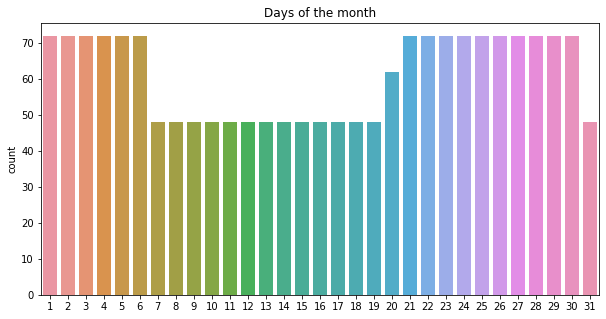

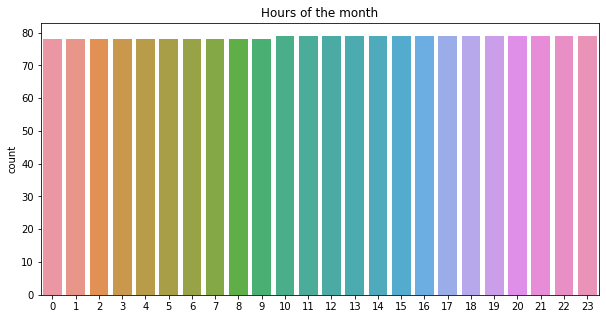

In [86]:
# Make sure the samples have an even number of days in the month and the hours
plt.figure(figsize = (10,5))
plt.title('Days of the month')
sns.countplot(dates)
plt.show()

plt.figure(figsize = (10,5))
plt.title('Hours of the month')
sns.countplot(hours)
plt.show()

In [87]:
# # Get sampled dfs for general corona tweets
control_df = pd.DataFrame()

# Get only conspiracy and url with news chanel related tweets
col_list = ['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location', 'text',
            'tweet_type', 'followers_count','favourites_count', 'verified', 'hashtag', 
            'mentionid','mentionsn','rt_userid','rt_screen','rt_rt_count','rt_fav_count',
            'rt_tweetid','urls_list','account_creation_date']

for i,file in tqdm(enumerate(sample_files)):
    control_df = control_df.append(pd.read_csv(file,usecols=col_list))
    break
control_df.shape

(36067, 21)

# Conspiracy theory analysis

In [88]:
def create_cloud(string,exclude = None):
    wordcloud = WordCloud(width=800,height=400,max_font_size=50, max_words=100,
                      collocations=False, background_color="white", stopwords = exclude
                     ).generate(string)

    # Display the generated image:
    plt.figure(figsize = (20,20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [89]:
# Find hashtags for tweets
def hash_tweets(string,df):
    tweets = df[df.hashtag.str.contains(string)]
    return tweets

In [90]:
# Find text for tweets
def text_tweets(string,df):
    tweets = df[df.text.str.contains(string)]
    return tweets

In [91]:
# Find urls for tweets
def url_tweets(string,df):
    tweets = df[df.urls_list.str.contains(string)]
    return tweets

In [92]:
# Get tweets, create a cloud, get users associated with each url substring
def get_hashtags_tweets(df,hashtag_list,cloud=True):
    users = set()
    hash_dict = {}
    hash_df = pd.DataFrame()

    for hashtag in hashtag_list:
        these_hashtags = hash_tweets(hashtag,df)
        hash_df = hash_df.append(these_hashtags)
        hash_dict[hashtag] = these_hashtags.screen_name.unique()
        these_users = list(these_hashtags.screen_name.unique())
        users.update(these_users)
        if cloud:
            related_hashs = ' '.join(these_hashtags.hashtag)
            try:
                create_cloud(related_hashs,exclude = [hashtag])
            except:
                pass
#         print(hashtag,len(these_users))
    
    return list(users), hash_dict, hash_df

In [93]:
# Get tweets, create a cloud, get users associated with each url substring
def get_url_usertweets(df,url_list):
    users = set()
    url_dict = {}
    url_df = pd.DataFrame()

    for url in url_list:
        these_urls = url_tweets(url,df)
        url_df = url_df.append(these_urls)
        url_dict[url] = these_urls.screen_name.unique()
        users.update(list(these_urls.screen_name.unique()))
    
    return list(users), url_dict, url_df

In [94]:
# Get tweets, create a cloud, get users associated with each url substring
def get_text_tweets(df,text_list):
    users = []
    text_dict = {}
    text_df = pd.DataFrame()

    for text in text_list:
        these_keyword = text_tweets(text,df)
        text_df = text_df.append(these_keyword)
        text_dict[text] = these_keyword.screen_name.unique()
        users += list(these_keyword.screen_name.unique())
    
    return users, text_dict, text_df

In [95]:
def unique(list1): 
    x = np.array(list1) 
    return np.unique(x)

In [96]:
""" 
Tweet Columns
       'tweetid', 'userid', 'screen_name', 'date', 'lang', 'location',
       'place_id', 'place_url', 'place_type', 'place_name', 'place_full_name',
       'place_country_code', 'place_country', 'place_bounding_box', 'text',
       'extended', 'coord', 'reply_userid', 'reply_screen', 'reply_statusid',
       'tweet_type', 'friends_count', 'listed_count', 'followers_count',
       'favourites_count', 'statuses_count', 'verified', 'hashtag',
       'urls_list', 'profile_pic_url', 'profile_banner_url', 'display_name',
       'date_first_tweet', 'account_creation_date', 'rt_urls_list',
       'mentionid', 'mentionsn', 'rt_screen', 'rt_userid', 'rt_text',
       'rt_hashtag', 'rt_qtd_count', 'rt_rt_count', 'rt_reply_count',
       'rt_fav_count', 'rt_tweetid', 'qtd_screen', 'qtd_userid', 'qtd_text',
       'qtd_hashtag', 'qtd_qtd_count', 'qtd_rt_count', 'qtd_reply_count',
       'qtd_fav_count', 'qtd_tweetid', 'qtd_urls_list'                         
"""

# rt_screen is who is being retweeted

" \nTweet Columns\n       'tweetid', 'userid', 'screen_name', 'date', 'lang', 'location',\n       'place_id', 'place_url', 'place_type', 'place_name', 'place_full_name',\n       'place_country_code', 'place_country', 'place_bounding_box', 'text',\n       'extended', 'coord', 'reply_userid', 'reply_screen', 'reply_statusid',\n       'tweet_type', 'friends_count', 'listed_count', 'followers_count',\n       'favourites_count', 'statuses_count', 'verified', 'hashtag',\n       'urls_list', 'profile_pic_url', 'profile_banner_url', 'display_name',\n       'date_first_tweet', 'account_creation_date', 'rt_urls_list',\n       'mentionid', 'mentionsn', 'rt_screen', 'rt_userid', 'rt_text',\n       'rt_hashtag', 'rt_qtd_count', 'rt_rt_count', 'rt_reply_count',\n       'rt_fav_count', 'rt_tweetid', 'qtd_screen', 'qtd_userid', 'qtd_text',\n       'qtd_hashtag', 'qtd_qtd_count', 'qtd_rt_count', 'qtd_reply_count',\n       'qtd_fav_count', 'qtd_tweetid', 'qtd_urls_list'                         \n"

In [97]:
# Conspiracy theory hashtags
keywords = []

general_keywords = []

qanon_keywords = ['qanon',
                  'greatawakening',
                  'wwg1wga',
                  'qarmy'
                 ]

all_keywords = list(set(keywords+general_keywords+qanon_keywords))

In [98]:
# News url substrings to look for in tweet url lists (Try sampling)

news_sources = ['msnbc',
                'nydailynews',
                'reuters',
                'foxnews',
                'cnn',
                'wsj',
                'huffpost',
                'nyt',
                'dailymail',
                'washingtonpost',
                'theguardian',
                'abcnews',
                'bbc',
                'usatoday',
                'infowars',
                'oann',
                'latimes',
                'cnbc',
                'boston',
                'yahoo',
                'chicagotribune',
                'msn',
                'breitbart'
               ]

### Get tweets from preprocessed csvs

Used once the conspiracy theory tweets have been found and saved

In [38]:
# Preprocessed csvs with only conspiracy and url tweets
df = pd.read_csv('')

FileNotFoundError: [Errno 2] No such file or directory: ''

In [37]:
df.shape

NameError: name 'df' is not defined

In [16]:
# Separate retweets from non retweets tweets
orig_df = df[pd.isnull(df['rt_userid'])]
rt_df = df.dropna(subset=['rt_userid'])

In [17]:
# Use if all df loaded from csv

tweet_df = df.dropna(subset=['hashtag'])
df = pd.DataFrame()

# Get only conspiracy and url with news chanel related tweets
col_list = ['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location', 'text',
            'tweet_type', 'followers_count','favourites_count', 'verified', 'hashtag', 
            'mentionid','mentionsn','rt_userid','rt_screen','rt_rt_count','rt_fav_count',
            'rt_tweetid','urls_list','account_creation_date']

# df = pd.DataFrame()
clouds= False

conspiracy_users=set()
general_users=set()
china_users=set()
bill_users=set()
fiveg_users=set()
hosp_users=set()
qanon_users=set()
antivax_users=set()  

url_dict = {}

tweet_df.reset_index(drop=True,inplace=True)
tweet_df = tweet_df.apply(lambda x: x.astype(str).str.lower())
tweet_df.replace('nan',np.nan,inplace=True)
tweet_df.hashtag = tweet_df.hashtag.str.replace("'", '')

conspiracy_users_h, conspiracy_dict_h, consps_df_h = get_hashtags_tweets(tweet_df,keywords,cloud=clouds)
general_users_h, general_dict_h, general_consps_df_h = get_hashtags_tweets(tweet_df,general_keywords,cloud=clouds)
china_users_h, china_dict_h, china_df_h = get_hashtags_tweets(tweet_df,china_keywords,cloud=clouds)
bill_users_h, bill_dict_h, bill_df_h = get_hashtags_tweets(tweet_df,bill_keywords,cloud=clouds)
fiveg_users_h, fiveg_dict_h, fiveg_df_h = get_hashtags_tweets(tweet_df,fiveg_keywords,cloud=clouds)
hosp_users_h, hosp_dict_h, hosp_df_h = get_hashtags_tweets(tweet_df,hosp_keywords,cloud=clouds)
qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets(tweet_df,qanon_keywords,cloud=clouds)
antivax_users_h, antivax_dict_h, antivax_df_h = get_hashtags_tweets(tweet_df,antivax_keywords,cloud=clouds)

conspiracy_users.update(conspiracy_users_h)
general_users.update(general_users_h)
china_users.update(china_users_h)
bill_users.update(bill_users_h)
fiveg_users.update(fiveg_users_h)
hosp_users.update(hosp_users_h)
qanon_users.update(qanon_users_h)
antivax_users.update(antivax_users_h)

tweet_df = tweet_df[tweet_df.urls_list!='[]']

# Get tweets, create a cloud, get users associated with each news source
url_users, url_dict_temp, news_url_df = get_url_usertweets(tweet_df,news_sources)
for urlkey,urlval in url_dict_temp.items():
    this_set = set(urlval)
    if url_dict.get(urlkey):
        this_set.update(url_dict.get(urlkey))
    url_dict[urlkey]=this_set

df = df.append(consps_df_h)
df = df.append(general_consps_df_h)
df = df.append(china_df_h)
df = df.append(bill_df_h)
df = df.append(fiveg_df_h)
df = df.append(hosp_df_h)
df = df.append(qanon_df_h)
df = df.append(antivax_df_h)

del tweet_df, news_url_df
gc.collect()

# df

plandemic 27546
scamdemic 22419
qanon 44808
greatawakening 19570
chinaliedpeopledied 19665
5gcoronavirus 751
chemtrails 1274
rfid 707
bioweapon 5094
falseflag 3094
deepstate 18527
psyop 1375
policestate 3942
billgates 41986
event201 4542
filmyourhospital 4241
coronahoax 5776
corona33 3
plandemic 27546
scamdemic 22419
coronahoax 5776
fakevirus 904
chinaliedpeopledied 19665
ccpvirus 28124
makechinapay 2972
chinamustpay 4591
chinaliedpeopledie 21218
chinesebioterrorism 1602
boycottchina 11789
chinaisasshoe 1262
chinavirusmadeinchina 312
chinazi 7465
fuckbillgates 250
gatesvirus 2149
billgatesisevil 2975
billgatesisnotourfriend 775
arrestbillgates 4052
billgatesbioterrorist 1892
billgatesisnotadoctor 92
exposebillgates 11008
5gvirus 45
5gcoronavirus 751
5gkill 355
5gcovid19connection 1
5gfake 2
5gchemtrails 1
stop5g 584
5gconspiracy 54
5gmindcontrol 91
filmyourhospital 4241
emptyhospital 608
qanon 44808
greatawakening 19570
wwg1wga 36824
qarmy 6799
antivax 3924
learntherisk 863
vaccinescau

28

### Get all tweets from raw tweet files

In [ ]:
# Use for processing all tweets from downloaded dataset

# Get only conspiracy and url with news chanel related tweets
col_list = ['tweetid', 'userid', 'screen_name', 'date', 'lang', 'location', 'text',
            'tweet_type', 'followers_count','favourites_count', 'verified', 'hashtag', 
            'mentionid','mentionsn','rt_userid','rt_screen','rt_rt_count','rt_fav_count',
            'rt_tweetid','urls_list','account_creation_date']

tot_df = pd.DataFrame()
df = pd.DataFrame()
qanon_df_h = pd.DataFrame()

clouds=False

conspiracy_users=set()
qanon_users=set()

url_dict = {}

for i,file in tqdm(enumerate(sample_files)):

    tweet_df = pd.read_csv(file,usecols=col_list)
    tweet_df.reset_index(drop=True,inplace=True)
    tweet_df = tweet_df.apply(lambda x: x.astype(str).str.lower())
    tweet_df.replace('nan',np.nan,inplace=True)
    tweet_df.hashtag = tweet_df.hashtag.str.replace("'", '')

    conspiracy_users_h, conspiracy_dict_h, consps_df_h = get_hashtags_tweets(tweet_df,keywords,cloud=clouds)
    qanon_users_h, qanon_dict_h, qanon_df__h = get_hashtags_tweets(tweet_df,qanon_keywords,cloud=clouds)
    
    tot_df = tot_df.append(tweet_df)
    qanon_df_h = qanon_df_h.append(qanon_df__h)
    
    conspiracy_users.update(conspiracy_users_h)
    qanon_users.update(qanon_users_h)
    
    tweet_df = tweet_df[tweet_df.urls_list!='[]']

    # Get tweets, create a cloud, get users associated with each news source
    url_users, url_dict_temp, news_url_df = get_url_usertweets(tweet_df,news_sources)
    for urlkey,urlval in url_dict_temp.items():
        this_set = set(urlval)
        if url_dict.get(urlkey):
            this_set.update(url_dict.get(urlkey))
        url_dict[urlkey]=this_set

    df = df.append(consps_df_h)
    df = df.append(qanon_df_h)

    df = df.append(news_url_df)

    if i % 100 == 0:
        df.to_csv('election_conspiracies_parsed_1.csv', index=False)
    
    del tweet_df, news_url_df
    gc.collect()

In [21]:
len(qanon_users)

3459

## Conspiracy theory wordclouds

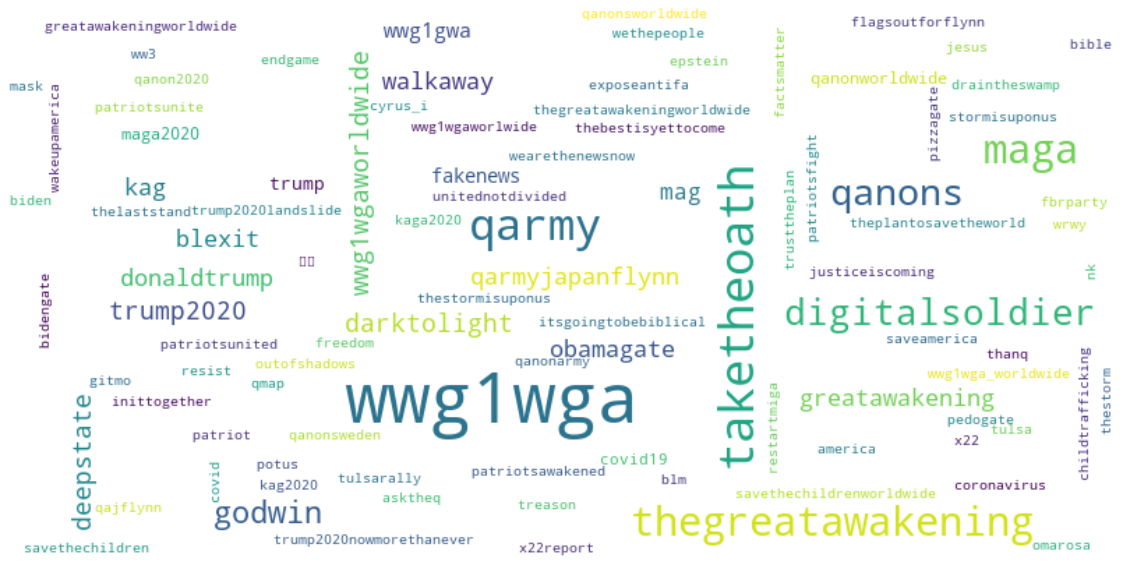

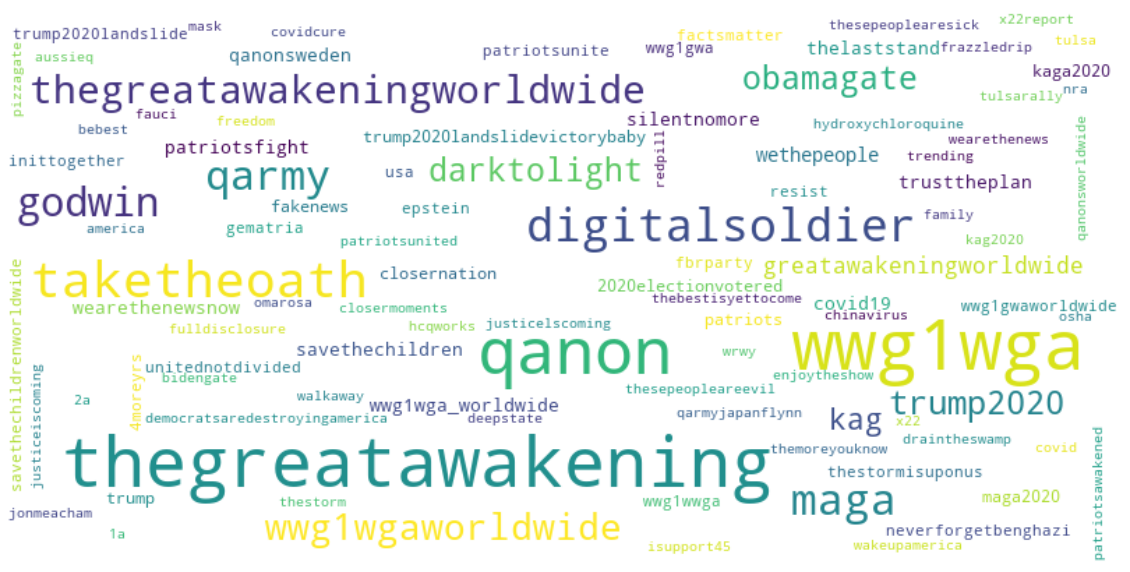

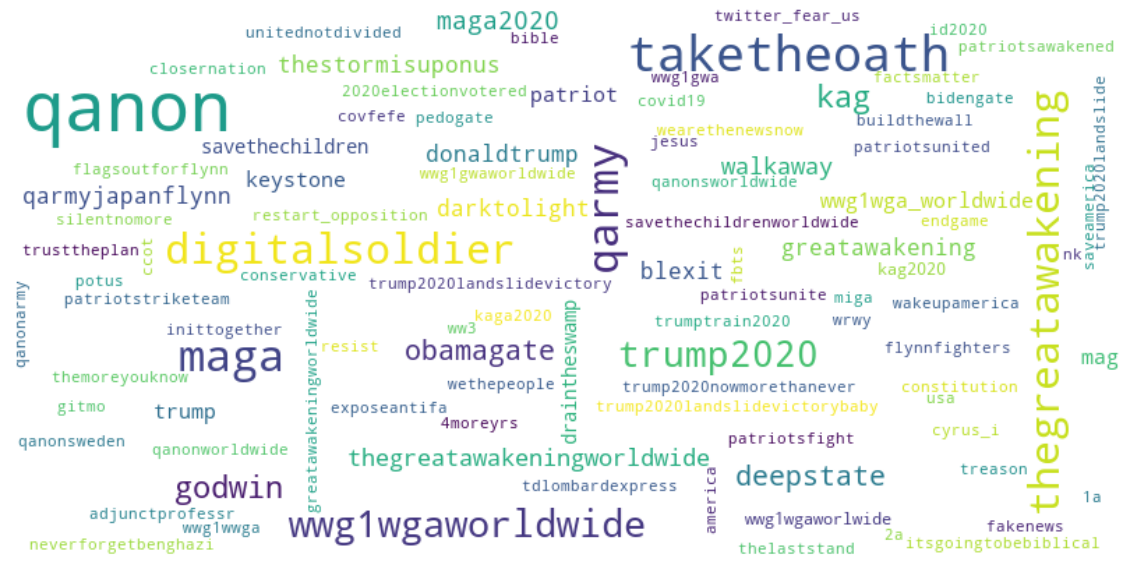

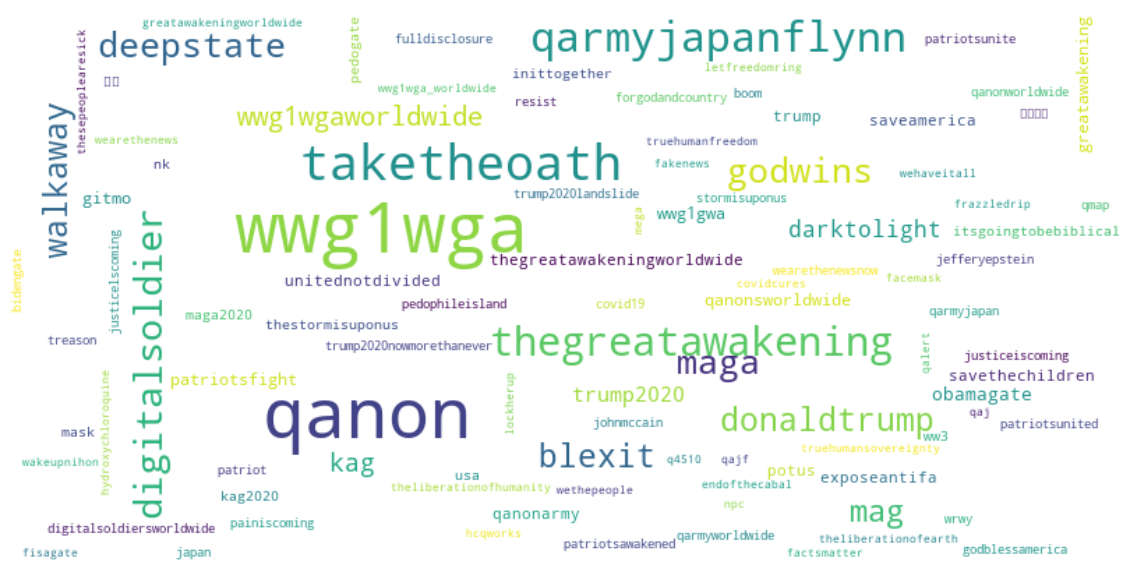

In [22]:
# Get users associated with conspiracy theories and plot wordclouds for related hashtags

clouds=True
conspiracy_users_h, conspiracy_dict_h, consps_df_h = get_hashtags_tweets(df.dropna(subset=['hashtag']),keywords,cloud=clouds)
qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets(df.dropna(subset=['hashtag']),qanon_keywords,cloud=clouds)

In [23]:
all_consp_hashtags_df = pd.concat([qanon_df_h],axis=0)
all_consp_hashtags_df.drop_duplicates(inplace=True)

In [24]:
print('Unique conspiracy tweeters:            ',len(list(set(conspiracy_users_h))))
print('Unique qanon conspiracy tweeters:      ',len(list(set(qanon_users_h))))

Unique conspiracy tweeters:             0
Unique qanon conspiracy tweeters:       3459


## Conspiracy keywords in tweet text

Looking at the tweet text instead of hashtags

In [49]:
conspiracy_users, conspiracy_dict, consps_df = get_text_tweets(df,keywords)
qanon_users, qanon_dict, qanon_df = get_text_tweets(df,qanon_keywords)

In [50]:
all_consp_text_df = pd.concat([qanon_df],axis=0)
all_consp_text_df.drop_duplicates(inplace=True)

In [48]:
print('Unique conspiracy tweeters:            ', len(list(set(conspiracy_users))))
print('Unique qanon conspiracy tweeters:      ', len(list(set(qanon_users))))

Unique conspiracy tweeters:             0
Unique qanon conspiracy tweeters:       2556


## News urls and conspiracies

In [25]:
# Urls and number of users
url_keys = url_dict.keys()
url_tots = [len(i) for i in url_dict.values()]

In [26]:
# All tweeters who tweet using conspiracy theory hashtags
all_consp_users = list(set(list(qanon_users)))
len(all_consp_users)

3459

In [27]:
# General (non conspiracy) tweeters who use urls from each sources
url_general_users = {}
for key,value in url_dict.items():
    url_general_users[key] = list(set(url_dict[key]).difference(set(all_consp_users)))
    
# Number of general (non conspiracy) tweeters who use urls from each sources
num_url_general = {}
for key,value in url_dict.items():
    num_url_general[key] = len((set(url_dict[key]).difference(set(all_consp_users))))
    
# Number of tweeters who use urls from each sources who tweet conspiracy theories
num_url_consp = {}
for key,value in url_dict.items():
    num_url_consp[key] = len((set(url_dict[key]).intersection(set(all_consp_users))))

# Tweeters who use specific news urls
url_consp_users = {}
for key,value in url_dict.items():
    url_consp_users[key] = set(url_dict[key]).intersection(set(all_consp_users))

In [28]:
url_consp_values = list(num_url_consp.values())
url_props = [vals/tots for vals,tots in zip(url_consp_values,url_tots)]

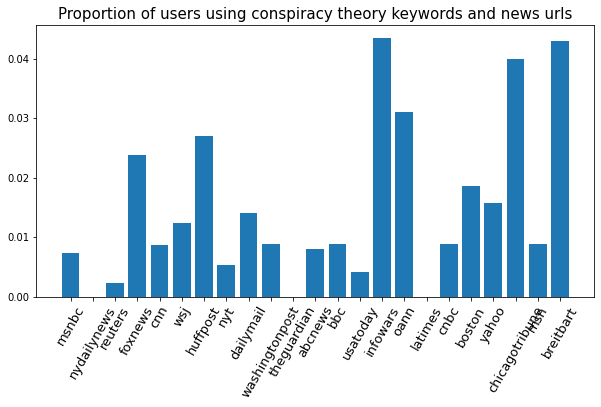

In [29]:
plt.figure(figsize=(10,5))
plt.title('Proportion of users using conspiracy theory keywords and news urls',size=15)
plt.bar(url_keys,url_props)
plt.xticks(rotation=60,fontsize=13)
plt.show()

In [30]:
# Heatmap matrix for each news website as proportion on users who also link to specific news sites
user_consp_dict = {'qanon':qanon_users}

heatmap_matrix = np.zeros((len(url_dict),len(user_consp_dict)))

for i,(urlkey,urlval) in enumerate(url_dict.items()):
    for j,(userkey,userval) in enumerate(user_consp_dict.items()):
        heatmap_matrix[i,j] = len((set(urlval).intersection(set(userval))))/(len(userval)*len(urlval))*100*100

In [31]:
num_user_keys = [consp + '\n' + str(len(user_consp_dict[consp])) + ' users' for consp in user_consp_dict.keys()]

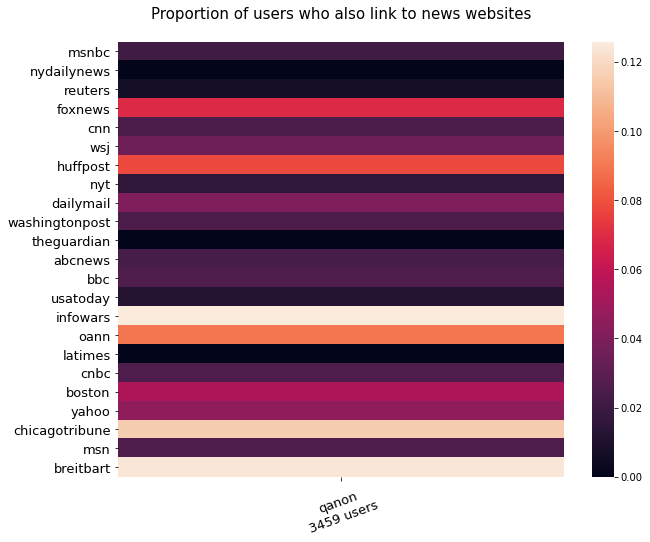

In [32]:
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_matrix, xticklabels=num_user_keys, yticklabels=news_sources,vmin=0)
plt.title('Proportion of users who also link to news websites\n',fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(rotation=20,fontsize=13)
plt.show()

### Drill down on bots

In [224]:
# general_botscores = 0

In [50]:
# Include non conspiracy theory users
user_consp_dict = {'qanon':qanon_users}

num_user_keys = [consp + '\n' + str(len(user_consp_dict[consp])) + ' users' for consp in user_consp_dict.keys()]

NameError: name 'general_botscores' is not defined

In [226]:
heatmap_matrix_bots = np.zeros((len(url_dict),len(user_consp_dict)))

for i,(urlkey,urlval) in enumerate(url_dict.items()):
    for j,(userkey,userval) in enumerate(user_consp_dict.items()):
        
        users = list(set(urlval).intersection(set(userval)))
        score_list = []
        for user in users:
            if all_botdict_en.get(user):
                score_list.append(all_botdict_en.get(user))
        if len(score_list) > 10:
            heatmap_matrix_bots[i,j] = sum(score_list)/len(score_list)
        else:
            heatmap_matrix_bots[i,j] = np.mean(list(all_botdict_en.values()))
        

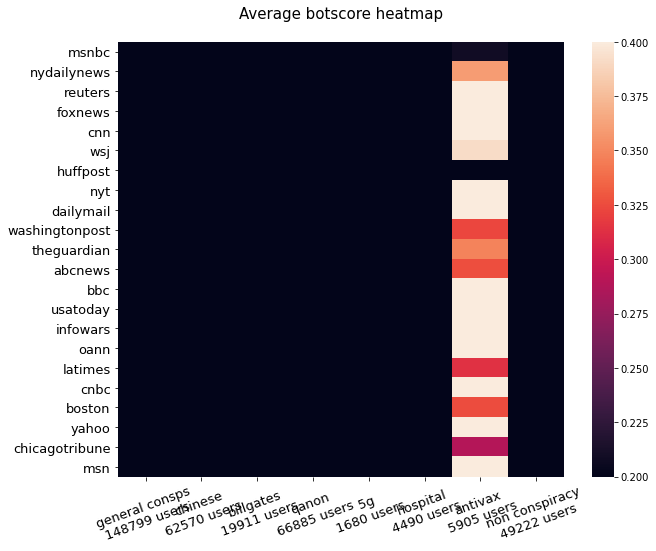

In [227]:
plt.figure(figsize=(10,8))
plt.title('Average botscore heatmap\n',fontsize=15)
sns.heatmap(heatmap_matrix_bots, xticklabels=num_user_keys, yticklabels=news_sources,vmax=0.4,vmin=0.2)
plt.yticks(fontsize=13)
plt.xticks(rotation=20,fontsize=13)
plt.show()

### Frequency plot of urls
General compared to conspiracy dataset

In [36]:
# Gets a dictionary of number of times urls are used above a threshold value
def get_url_counts(df,num_urls):
    url_df = df[df.urls_list != '[]'].reset_index()
    url_freq = [] 
    for i, row in url_df.iterrows():
        for url in ast.literal_eval(row.urls_list):
            url_freq.append(url['display_url'].split('/')[0])
            
    url_counts = Counter(url_freq)
    sorted_urls = {k: v for k, v in sorted(url_counts.items(), key=lambda item: item[1],reverse=True)[:num_urls]}
    print(sorted_urls)
    return sorted_urls

In [37]:
sorted_control_urls = get_url_counts(tot_df,30)
# sorted_control_urls = get_url_counts(control_df,30)
sorted_consp_urls = get_url_counts(df,30)
# sorted_consp_urls = get_url_counts(df,30)

{'twitter.com': 59161, 'youtu.be': 7061, 'youtube.com': 2862, 'pscp.tv': 2331, 'cnn.com': 1656, 'breitbart.com': 1612, 'bit.ly': 1596, 'nytimes.com': 1392, 'foxnews.com': 1271, 'washingtonpost.com': 1181, 'facebook.com': 1140, 'nypost.com': 985, 'google.com': 950, 'dailycaller.com': 779, 'iwillvote.com': 751, 'oann.com': 727, 'fiverr.com': 691, 'thehill.com': 646, 'thegatewaypundit.com': 599, 'thefederalist.com': 579, 'nbcnews.com': 565, 'rawstory.com': 563, 'politico.com': 559, 'donaldjtrump.com': 541, 'gjarr.it': 493, 'apple.news': 486, 'm.youtube.com': 476, 'cbsnews.com': 470, 'theguardian.com': 414, 'reuters.com': 413}
{'cnn.com': 1658, 'breitbart.com': 1626, 'nytimes.com': 1442, 'foxnews.com': 1305, 'twitter.com': 1288, 'washingtonpost.com': 1204, 'oann.com': 727, 'reuters.com': 435, 'theguardian.com': 426, 'google.com': 392, 'wsj.com': 314, 'news.yahoo.com': 306, 'huffpost.com': 287, 'msnbc.com': 264, 'pscp.tv': 260, 'cnbc.com': 255, 'yahoo.com': 234, 'usatoday.com': 233, 'dailym

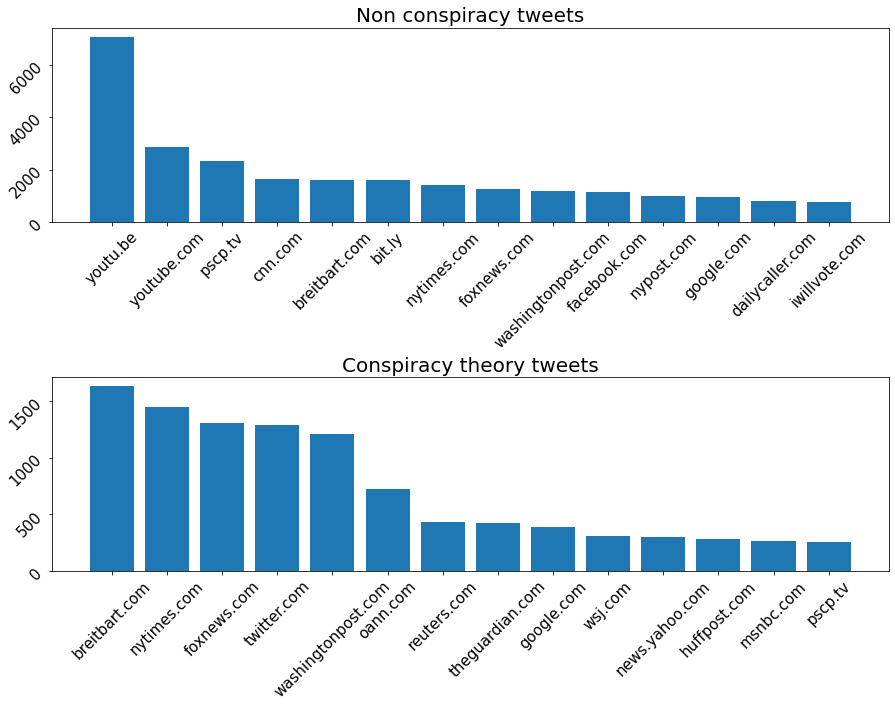

In [35]:
fig, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].bar(list(sorted_control_urls.keys())[1:15], list(sorted_control_urls.values())[1:15])
ax[0].set_title('Non conspiracy tweets',fontsize=20)
ax[1].bar(list(sorted_consp_urls.keys())[1:15], list(sorted_consp_urls.values())[1:15])
ax[1].set_title('Conspiracy theory tweets',fontsize=20)
ax[0].tick_params(labelrotation=45,labelsize=15)
ax[1].tick_params(labelrotation=45,labelsize=15)
plt.subplots_adjust(hspace = 0.8)
plt.show()

### Temporal analysis

In [81]:
# Maps tweet df date record to pd.Timestamp
def get_date(x):
    date_parts = x.split(' ')
    date = '-'.join([date_parts[1]] + [date_parts[2]] + [date_parts[5]])
    return pd.Timestamp(date)

In [54]:
# # Maps tweet df date and hour record to pd.Timestamp
def get_date_hour(x):
    date_parts = x.split(' ')
    if len(date_parts) < 5:
        return pd.Timestamp('00:00:00')
    date = '-'.join([date_parts[1]] + [date_parts[2]] + [date_parts[5]]) 
    date = pd.Timestamp(date) + pd.Timedelta(hours = int(date_parts[3][0:2]))
    return date

# dates_df = df.date.apply(get_date_hour)

In [82]:
# Create placeholder df for dates
df.date = df.date.apply(get_date)
date_df = pd.DataFrame(columns=list(user_consp_dict.keys()),index=pd.date_range(start=df.date.min(),end=df.date.max()))
date_df.fillna(0,inplace=True)

In [83]:
for consp_df, consp_name in zip([qanon_df_h],list(user_consp_dict.keys())):
    dates = consp_df.date.apply(get_date)
    for date in dates.values:
        date_df.loc[date,consp_name] += 1

date_df.describe()

qanon
count    76.000000
mean     87.315789
std     231.266323
min       0.000000
25%       0.000000
50%       0.000000
75%      16.500000
max    1460.000000

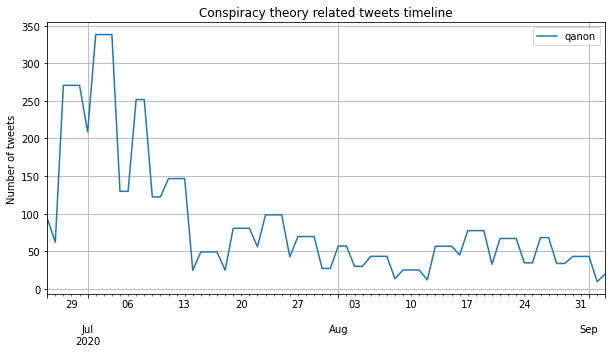

In [84]:
# Smoothed volume of consp hashtags over time
rolling_mean = date_df.rolling(7).mean().dropna()
rolling_mean.plot(y=date_df.columns,use_index=True,figsize=(10,5),fontsize=10)
plt.ylabel('Number of tweets')
plt.title('Conspiracy theory related tweets timeline')
plt.grid()

# Bot analysis

## Get user handles for botometer

Getting screen names to query using Botometer

In [38]:
account_totals = df[['userid','screen_name']].groupby(['userid','screen_name']).size()
account_totals.sort_values(ascending=False)

KeyboardInterrupt: 

In [131]:
account_totals = account_totals.sort_values(ascending=False)

/Users/jaimin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [118]:
url_props = [vals/tots for vals,tots in zip(url_consp_values,url_tots)]

## Load botscore queries

In [75]:
# Get botometer scores from conspiracy users
def botometer_query(filename,name_list):

    rapidapi_key = "6ac8fe69aamshcc30411e7824b49p12a1cajsnc2267278951c" # now it's called rapidapi key
    twitter_app_auth = {
        'consumer_key': 'DPIuUoHQsmaeK7UCyQZPxk1pD',
        'consumer_secret': 'SLDDw1VCdbF1ZpWl8xnNRekgw2Occd7ltVPuxo4tfyTZRPd8aq',
        'access_token': '1239432784319406080-vcW86zKro0M7e5pszZvRvAyXIVFy96',
        'access_token_secret': 'VlphE7Es3sjviibpmCmpTT1GdbZ180awYtE6FpKHR6qhl',
      }

    botometer_api_url = 'https://botometer-pro.p.rapidapi.com'
    bom = botometer.Botometer(botometer_api_url=botometer_api_url,
                              wait_on_ratelimit=True,
                              rapidapi_key=rapidapi_key,
                              **twitter_app_auth)

    # Check a single account by screen name
    result = bom.check_account('@clayadavis')

    # Check a single account by id
    result = bom.check_account(1548959833)

    # Check a sequence of accounts
    for screen_name, result in bom.check_accounts_in(name_list):

        this_acc = screen_name
        with open(filename, 'a+') as file:
            file.write('%s\n' % json.dumps(result))

In [144]:
# Returns a list of jsons of each uesr
def read_bot_csv(csv_name):
    file = open(csv_name)
    return file.readlines()

In [145]:
def get_antivax_botscores(df):
    cols = ['screen_name', 'english_botscore']
    user_scores = pd.DataFrame(columns = cols)
    for i in range(len(df)):
        botjson = json.loads(df.iloc[i].json)
        if botjson.get('user').get('user_data'):
            user_scores = user_scores.append(pd.DataFrame({'screen_name':[botjson['user']['user_data']['screen_name']].lower(), 
                                     'english_botscore':[botjson['cap']['english']]}))
        else:
            user_scores = user_scores.append(pd.DataFrame({'screen_name':[botjson['user']['screen_name']].lower(), 
                                     'english_botscore':[botjson['cap']['english']]}))
    user_scores.reset_index(inplace=True,drop=True)
    return user_scores

In [194]:
# Get dictionary of botscores from list of botometer json
def users_dict(json_list):
    bot_dict = {}
    for user in json_list:
        this_user = json.loads(user)
        if this_user.get('user'):
            if this_user.get('user').get('user_data'):
                bot_dict[this_user['user']['user_data']['screen_name'].lower()] = this_user['cap']['english']
            else:
                bot_dict[this_user['user']['screen_name'].lower()] = this_user['cap']['english']
    return bot_dict

In [191]:
df = pd.read_csv('Botometer_results/antivax_results_jsons.csv')

In [195]:
botscore_files = ['Botometer_results/' + i for i in os.listdir('Botometer_results/') if i[-3:] == 'csv']

all_botscores = []
all_botdict_en = {}
for botfile in botscore_files:
    if botfile.startswith('Botometer_results/antivax_results_jsons'):
        continue
    elif botfile.startswith('Botometer_results/antivax'):
        these_botscores = read_bot_csv(botfile)
    else:
        these_botscores = read_bot_csv(botfile)
    all_botdict_en.update(users_dict(these_botscores))
    all_botscores += these_botscores

In [196]:
print('Number of botscores:',len(all_botscores))
print('Number of botscores:',len(all_botdict_en))

Number of botscores: 298770
Number of botscores: 128351


In [197]:
general_bot_files = [i for i in botscore_files if 'general' in i]
general_botscores = {}

for file in general_bot_files:
    these_scores = read_bot_csv(file)
    general_botscores.update(users_dict(these_scores))
len(general_botscores)

49222

In [198]:
consp_bot_files = [i for i in botscore_files if 'consp' in i]
consp_botscores = {}

for file in consp_bot_files:
    these_scores = read_bot_csv(file)
    consp_botscores.update(users_dict(these_scores))

In [199]:
len(consp_botscores)

78897

In [200]:
# For url users for baseline comparison
url_bot_files = ['Botometer_results/botometer_general_06_03_unfinished.csv',
                  'Botometer_results/botometer_general_url - Copy.csv',
                  'Botometer_results/botometer_general_url_2 - Copy.csv',
                  'Botometer_results/url_general_bot_queries.csv',
                ]

url_bot_files = [
                  'Botometer_results/botometer_general_url - Copy.csv',
                  'Botometer_results/botometer_general_url_2 - Copy.csv',
                  'Botometer_results/url_general_bot_queries.csv',
                ]

url_botscores = {}

for file in url_bot_files:
    these_scores = read_bot_csv(file)
    url_botscores.update(users_dict(these_scores))

In [201]:
# # Find Conspiracy theory users
rt_scored_users = list(rt_df[rt_df['screen_name'].isin(set(all_botdict_en.keys()))].screen_name.unique())
orig_scored_users = list(orig_df[orig_df['screen_name'].isin(set(all_botdict_en.keys()))].screen_name.unique())

In [202]:
# Get lists of scores
rt_scores = []
orig_scores = []
for name in rt_scored_users:
    rt_scores.append(all_botdict_en[name])
for name in orig_scored_users:
    orig_scores.append(all_botdict_en[name])

## Botscore Results

In [203]:
print(sum(rt_scores)/len(rt_scores))
print(sum(orig_scores)/len(orig_scores))

0.07071353284741491
0.061737166922329736


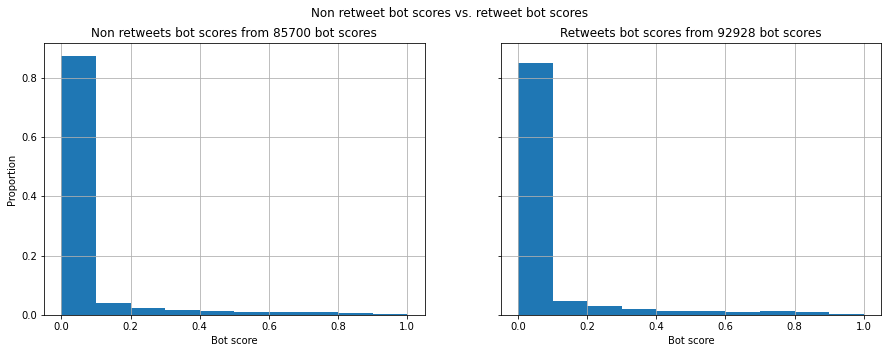

In [204]:
# Bot scores
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
fig.suptitle('Non retweet bot scores vs. retweet bot scores')
ax[0].set_ylabel('Proportion')
ax[0].set_xlabel('Bot score')

ax[0].hist(orig_scores, weights=np.ones(len(orig_scores))/len(orig_scores))
ax[0].set_title('Non retweets bot scores from %d bot scores' % len(orig_scores))
ax[0].grid()

ax[1].set_xlabel('Bot score')
ax[1].hist(rt_scores, weights=np.ones(len(rt_scores))/len(rt_scores))
ax[1].set_title('Retweets bot scores from %d bot scores' % len(rt_scores))
ax[1].grid()
plt.show()

In [205]:
# Comparing botscores for conspiracy theories vs non conspiracy theoies
botvals_general = list(general_botscores.values())
botvals_consp = list(consp_botscores.values())

In [206]:
print('General',sum(botvals_general)/len(botvals_general))
print('Conspiracy',sum(botvals_consp)/len(botvals_consp))

General 0.053641498434632444
Conspiracy 0.06980268171802326


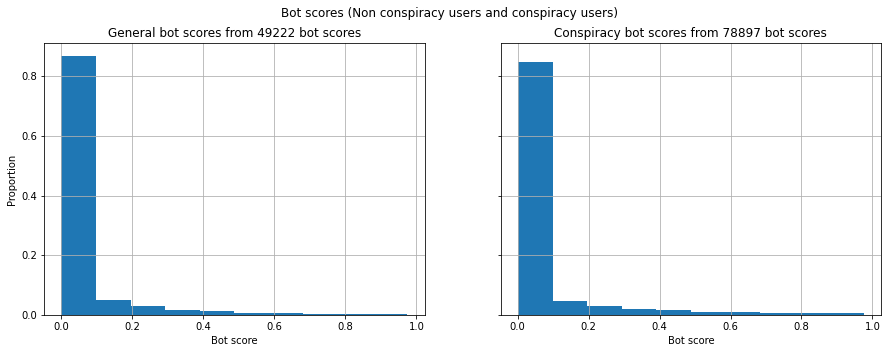

In [207]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
fig.suptitle('Bot scores (Non conspiracy users and conspiracy users)')

ax[0].set_ylabel('Proportion')
ax[0].set_xlabel('Bot score')
ax[0].hist(botvals_general, weights=np.ones(len(botvals_general)) / len(botvals_general))
ax[0].set_title('General bot scores from %d bot scores' % len(botvals_general))
ax[0].grid()

ax[1].set_xlabel('Bot score')
ax[1].hist(botvals_consp, weights=np.ones(len(botvals_consp)) / len(botvals_consp))
ax[1].set_title('Conspiracy bot scores from %d bot scores' % len(botvals_consp))
ax[1].grid()
plt.show()

In [208]:
non_consp_users = set(list(general_botscores.keys()))

In [209]:
# Get botscores for each conspiracy theory
all_botdict_en_china = {}
all_botdict_en_bill = {}
all_botdict_en_qanon = {}
all_botdict_en_hosp = {}
all_botdict_en_fiveg = {}
all_botdict_en_antivax = {}
all_botdict_en_non_consp = {}

# all_botuser_set = set(all_botdict_en.keys())
for screen_name in all_botdict_en.keys():
    if screen_name in china_users:
        all_botdict_en_china[screen_name] = all_botdict_en[screen_name]
    if screen_name in bill_users:
        all_botdict_en_bill[screen_name] = all_botdict_en[screen_name]
    if screen_name in qanon_users:
        all_botdict_en_qanon[screen_name] = all_botdict_en[screen_name]
    if screen_name in hosp_users:
        all_botdict_en_hosp[screen_name] = all_botdict_en[screen_name]
    if screen_name in fiveg_users:
        all_botdict_en_fiveg[screen_name] = all_botdict_en[screen_name]
    if screen_name in antivax_users:
        all_botdict_en_antivax[screen_name] = all_botdict_en[screen_name]
    if screen_name in non_consp_users:
        all_botdict_en_non_consp[screen_name] = all_botdict_en[screen_name]
    
print(len(all_botdict_en_china))
print(len(all_botdict_en_bill))
print(len(all_botdict_en_qanon))
print(len(all_botdict_en_hosp))
print(len(all_botdict_en_fiveg))
print(len(all_botdict_en_antivax))
print(len(all_botdict_en_non_consp))

33356
6748
25125
3233
911
2441
49222


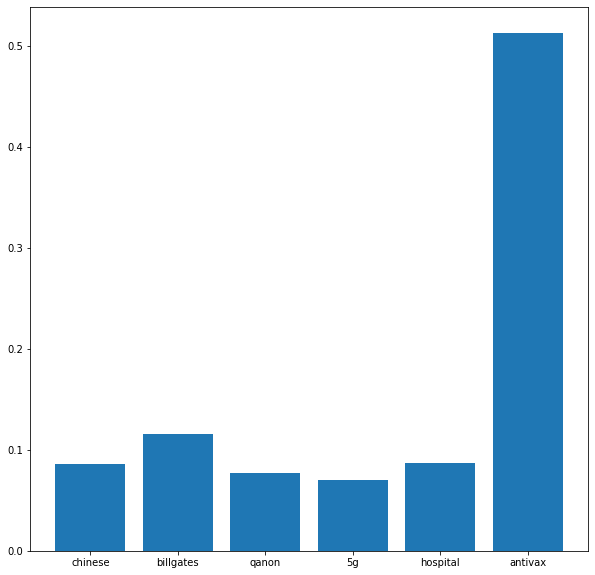

In [211]:
# Average botscore for each group of conspiracy theory users
fig = plt.figure(figsize = (10,10))

avg_botscores= [sum(list(all_botdict_en_china.values()))/len(all_botdict_en_china.values()),
                sum(list(all_botdict_en_bill.values()))/len(all_botdict_en_bill.values()),
                sum(list(all_botdict_en_qanon.values()))/len(all_botdict_en_qanon.values()),
                sum(list(all_botdict_en_hosp.values()))/len(all_botdict_en_hosp.values()),
                sum(list(all_botdict_en_fiveg.values()))/len(all_botdict_en_fiveg.values()),
                sum(list(all_botdict_en_antivax.values()))/len(all_botdict_en_antivax.values())]
#                 sum(list(all_botdict_en_non_consp.values()))/len(all_botdict_en_non_consp.values())]

plt.bar(list(user_consp_dict.keys())[1:],avg_botscores)

plt.show()

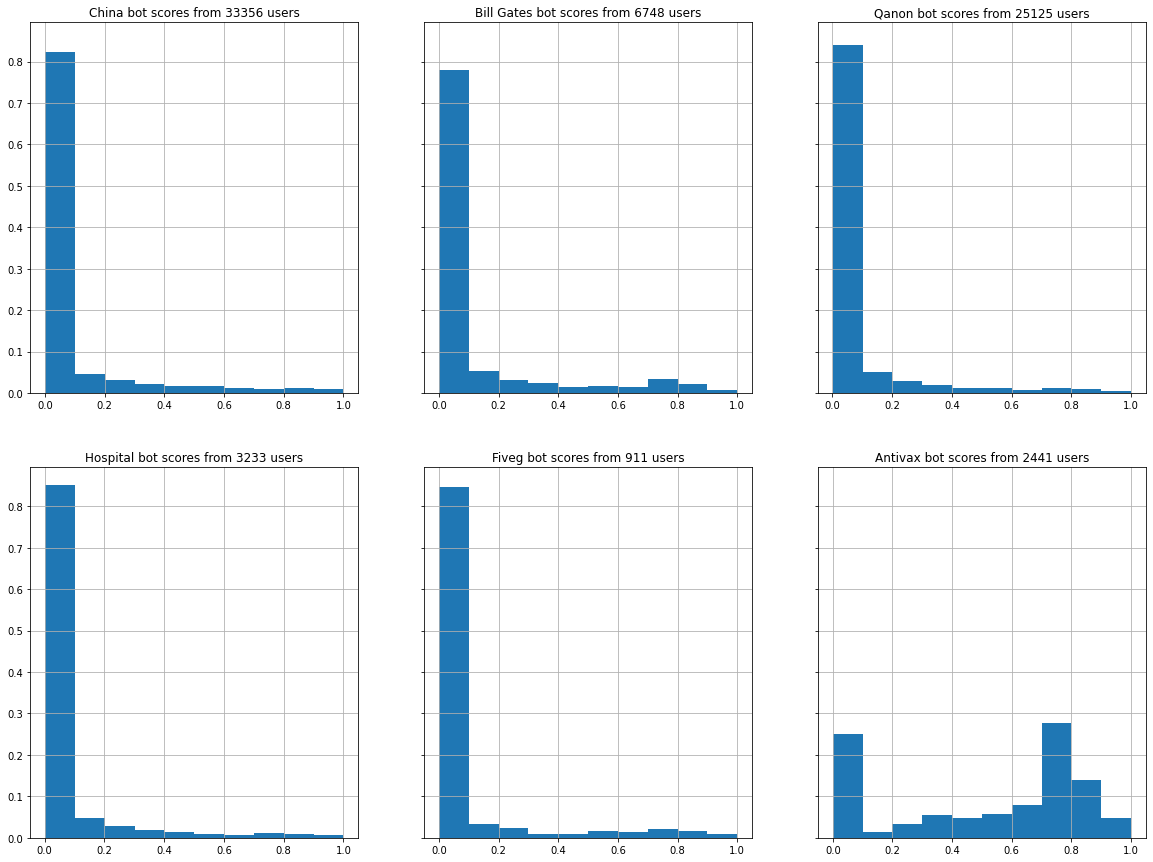

In [212]:
fig, ax = plt.subplots(2,3,figsize=(20,15) ,sharey=True)

ax[0,0].hist(all_botdict_en_china.values(), weights=np.ones(len(all_botdict_en_china)) / len(all_botdict_en_china))
ax[0,0].set_title('China bot scores from %d users' % len(all_botdict_en_china))
ax[0,0].grid()

ax[0,1].hist(all_botdict_en_bill.values(), weights=np.ones(len(all_botdict_en_bill)) / len(all_botdict_en_bill))
ax[0,1].set_title('Bill Gates bot scores from %d users' % len(all_botdict_en_bill))
ax[0,1].grid()

ax[0,2].hist(all_botdict_en_qanon.values(), weights=np.ones(len(all_botdict_en_qanon)) / len(all_botdict_en_qanon))
ax[0,2].set_title('Qanon bot scores from %d users' % len(all_botdict_en_qanon))
ax[0,2].grid()

ax[1,0].hist(all_botdict_en_hosp.values(), weights=np.ones(len(all_botdict_en_hosp)) / len(all_botdict_en_hosp))
ax[1,0].set_title('Hospital bot scores from %d users' % len(all_botdict_en_hosp))
ax[1,0].grid()

ax[1,1].hist(all_botdict_en_fiveg.values(), weights=np.ones(len(all_botdict_en_fiveg)) / len(all_botdict_en_fiveg))
ax[1,1].set_title('Fiveg bot scores from %d users' % len(all_botdict_en_fiveg))
ax[1,1].grid()

ax[1,2].hist(all_botdict_en_antivax.values(), weights=np.ones(len(all_botdict_en_antivax)) / len(all_botdict_en_antivax))
ax[1,2].set_title('Antivax bot scores from %d users' % len(all_botdict_en_antivax))
ax[1,2].grid()

plt.show()

# Find significant users

Finding prominent misinformation spreaders 

In [73]:
# Split into high and low botscores

In [74]:
# Split into high and low botscores
# Create dataframe for each user
# Columns = ['Number of tweets','Follower count','% Retweets','Account creation date','Botscore',All URLS, ALL CONSPIRACIES]

In [37]:
# conspiracies = [consp for consp in user_consp_dict.keys()]

In [202]:
user_columns = ['Screen Name','Botscore','Covid Tweets','Follower Count','Favourites Count','Retweets Count',
                'Non Retweets Count','Account Created','Location','Retweeted Count', 'Mentioned Count','Language',
                'User ID'] + [consp for consp in user_consp_dict.keys()]

user_df = pd.DataFrame(columns = user_columns)

In [203]:
from ast import literal_eval

In [244]:
# df.isna().sum()

In [35]:
# Create the dataframe adding information for each tweet
user_df = pd.DataFrame(columns = user_columns)
already_added = dict()
already_added_id = dict()
retweet_dict = dict()
mention_dict = dict()

counter = 0
for index, row in tqdm(df.iloc[:,:].dropna(subset='followers_count').iterrows()):
    break
    
    if int(row['followers_count']) < 1000:
        continue
    else:

        # If its a new entry
        if row['screen_name'] not in already_added:
            added = False

            already_added[row['screen_name']] = counter
            already_added_id[row['userid']] = counter

            user_row = pd.Series(index=user_columns).fillna(0)
            user_row['Screen Name','Follower Count','Favourites Count','User ID','Account Created','Location'
                     ,'Language'] = row[['screen_name','followers_count','favourites_count','user_id',
                     'account_creation_date','location','lang']].values        

            # Botscores
            user_row['Botscore'] = all_botdict_en.get(row['screen_name'])
            counter += 1

        # If there is already an entry for this user
        else:
            added = True
            idx = already_added[row['screen_name']]
            user_row = user_df.iloc[idx,:]

        user_row['Covid Tweets'] = user_row['Covid Tweets'] + 1

        if np.isnan(row['rt_userid']):
            user_row['Non Retweets Count'] = user_row['Non Retweets Count'] + 1
        else:
            user_row['Retweets Count'] = user_row['Retweets Count'] + 1
            if retweet_dict.get(row['rt_userid']):
                retweet_dict[row['rt_userid']] = retweet_dict[row['rt_userid']] + 1
            else:
                retweet_dict[row['rt_userid']] = 1

        # Add to mention and retweet count
        if type(row['mentionsn']) == str:
            if len(row['mentionsn']) > 2:
                mentions = literal_eval(row['mentionsn'])
                for mentionsn in mentions:
                    if mention_dict.get(mentionsn):
                        mention_dict[mentionsn] = mention_dict[mentionsn] + 1
                    else:
                        mention_dict[mentionsn] = 1

        # Add to user index
        if row['screen_name'] in general_users:
            user_row['general conspiracies'] = user_row['general conspiracies'] + 1

        if row['screen_name'] in china_users:
            user_row['china lies'] = user_row['china lies'] + 1

        if row['screen_name'] in bill_users:
            user_row['billgates'] = user_row['billgates'] + 1

        if row['screen_name'] in fiveg_users:
            user_row['5g'] = user_row['5g'] + 1

        if row['screen_name'] in hosp_users:
            user_row['hospital'] = user_row['hospital'] + 1

        if row['screen_name'] in qanon_users:
            user_row['qanon'] = user_row['qanon'] + 1

#         for url, url_vals in url_consp_users.items():
#             if row['screen_name'] in url_vals:
#                 user_row[url] = user_row[url] + 1

        if not added:
            user_df = user_df.append(user_row,ignore_index=True)
        else:
            user_df.update(pd.DataFrame(user_row).T)

# user_df

NameError: name 'user_columns' is not defined

In [25]:
# {k: v for k, v in sorted(mention_dict.items(), key=lambda item: item[1], reverse=True)}

In [338]:
for i,row in tqdm(user_df.iloc[:,:].iterrows()):
    if row['followers_count'] < 1000:
        pass
    else:

In [345]:
# user_df.to_csv('tweeter_info.csv')
user_df.sort_values('Covid Tweets',ascending=False)
# user_df.sort_values('Botscore')

Screen Name  Botscore Covid Tweets Follower Count Favourites Count  \
1068      r__worldnews   0.70642          303            214                0   
455          viriyabot  0.813872          211            861               56   
894       skowtura_ini      None          204            608              118   
279            dubvnow      None          144          11030            51785   
17143  baronianconsult      None          128           1601            80902   
...                ...       ...          ...            ...              ...   
30555   mariaeugeniarc      None            1            585            13885   
30556      tbygracezhu      None            1           1021              169   
30557      drjoaquinid      None            1             92               39   
30558      lamichhanen      None            1            538             3286   
74331  chrisre69812588      None            1              1                3   

      Retweets Count Non Retweets Count                 Account Created  \
1068               0                303  fri dec 29 19:18:05 +0000 2017   
455              211                  0  thu jul 14 12:47:03 +0000 2016   
894                0                204  sat jan 31 01:55:19 +0000 2015   
279                0                144  mon mar 19 01:02:16 +0000 2012   
17143             53                 75  wed jun 05 21:52:49 +0000 2013   
...              ...                ...                             ...   
30555              0                  1  thu mar 25 21:03:13 +0000 2010   
30556              0                  1  mon jun 22 11:59:25 +0000 2009   
30557              1                  0  mon jul 22 14:52:36 +0000 2019   
30558              0                  1  sat sep 07 11:27:20 +0000 2013   
74331              1                  0  wed oct 16 19:03:19 +0000 2019   

               Location Retweeted Count  ... boston yahoo  chicagotribune  \
1068                NaN               0  ...      0     0               0   
455            internet               0  ...    211   211               0   
894                  uk               0  ...    204   204             204   
279      morgantown, wv               0  ...      0     0               0   
17143               NaN               0  ...      0     0               0   
...                 ...             ...  ...    ...   ...             ...   
30555            mexico               0  ...      0     0               0   
30556           beijing               0  ...      0     0               0   
30557               NaN               0  ...      0     0               0   
30558  bharatpur, nepal               0  ...      0     0               0   
74331               NaN               0  ...      0     0               0   

       msn general conspiracies china lies billgates qanon 5g hospital  
1068     0                    0          0         0     0  0        0  
455    211                    0        211         0     0  0        0  
894    204                    0          0         0     0  0        0  
279      0                    0          0         0     0  0        0  
17143    0                    0          0         0     0  0        0  
...    ...                  ...        ...       ...   ... ..      ...  
30555    0                    0          0         0     0  0        0  
30556    0                    0          0         0     0  0        0  
30557    0                    0          0         0     0  0        0  
30558    0                    0          0         0     0  0        0  
74331    0                    0          0         0     0  0        0  

[74332 rows x 41 columns]

In [324]:
# with open('retweet_dict.json','w') as file:
#     json.dump(retweet_dict,file)
# # with open('url_users.json', 'w') as outfile:
# #     json.dump(str(url_general_users), outfile)
# with open('mention_dict.json','w') as file:
#     json.dump(mention_dict,file)
# user_df = pd.read_csv('tweeter_info.csv',index_col=0)
# user_df.sort_values('Retweeted Count')
# with open('jsons/mention_dict.json') as json_file:
#     mention_dict_old = json.load(json_file)

In [58]:
df.describe()

tweetid    userid    screen_name  \
count                322686    322686         322686   
unique               176594     90018          90706   
top     1254093321829580801  49992656  joyceramgatie   
freq                     11      1436           1436   

                                  date    lang       location  \
count                           322686  322686         186684   
unique                          170031      52          21571   
top     wed apr 08 02:49:03 +0000 2020      en  united states   
freq                                14  250226          11043   

                                                     text  \
count                                              322686   
unique                                             107833   
top     rt @qnotables1: soros owns biotech company in ...   
freq                                                 2247   

                             tweet_type followers_count favourites_count  \
count                            322686          322686           322686   
unique                                4           20465            62058   
top     retweeted_tweet_without_comment               0                0   
freq                             115756            4679             2891   

       verified  hashtag urls_list           account_creation_date mentionid  \
count    322686   322686    322686                          322686    322686   
unique        2    61465     31107                           89996     31719   
top       false  [qanon]        []  tue jun 23 14:39:59 +0000 2009        []   
freq     322171    19186    240536                            1436    102377   

       mentionsn              rt_userid  
count     322686                 115756  
unique     31811                   9148  
top           []  1.163085970901631e+18  
freq      102377                   2887

## Original Tweets

In [201]:
# Only include original tweets
all_df = orig_df[orig_df.tweet_type == 'original']
all_df.dropna(subset=['hashtag'],inplace=True)
all_df[['followers_count','favourites_count']] = all_df[['followers_count','favourites_count']].astype('float')

/Users/jaimin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [202]:
bill_df = all_df[all_df['screen_name'].isin(bill_users)]
fiveg_df = all_df[all_df['screen_name'].isin(fiveg_users)]
china_df = all_df[all_df['screen_name'].isin(china_users)]
hosp_df = all_df[all_df['screen_name'].isin(hosp_users)]

### By follower count

In [203]:
print(bill_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
bill_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['dalenekurtis' 'jamierodr14' 'libertytarian' 'no_democrats' 'kidkool4u'
 'hickorymtnman' 'bamafanaticfan1' 'sherry25793049' 'tmzedg'
 'eavesdropann' 'christinepolon1' 'stephphilip8' 'notunderdog'
 'jpharley3000' 'enki74' 'yourauntiemame' 'toscaausten' 'chesleydohl'
 'jebeess34' 'viku1111']


tweetid              userid      screen_name  \
129868   1222517778973851649           244241866     dalenekurtis   
1423373  1238975687790415872          3353061012      jamierodr14   
2156944  1252710238656040969           590211920    libertytarian   
307205   1224689435226394626            59461030     no_democrats   
2342953  1255668392972955649          2827135812        kidkool4u   
2291235  1254775975222456321  914154046382051328    hickorymtnman   
2155183  1252698632895311877  997312910748680192  bamafanaticfan1   
1182755  1235040423002992640  949672435690934274   sherry25793049   
2138593  1252395308660613120  996576181251117056           tmzedg   
2268906  1254380037232635904           134240162     eavesdropann   

                                   date lang                        location  \
129868   wed jan 29 13:52:06 +0000 2020   en  newport beach,ca•nashville,tn    
1423373  sat mar 14 23:49:57 +0000 2020   en                         georgia   
2156944  tue apr 21 21:26:09 +0000 2020   en                              tx   
307205   tue feb 04 13:41:29 +0000 2020   en                             usa   
2342953  thu apr 30 01:20:48 +0000 2020   en                 toronto, on, ca   
2291235  mon apr 27 14:14:39 +0000 2020   en                             NaN   
2155183  tue apr 21 20:40:02 +0000 2020   en                              tx   
1182755  wed mar 04 03:12:37 +0000 2020   en                     chicago, il   
2138593  tue apr 21 00:34:44 +0000 2020   en                    columbus, oh   
2268906  sun apr 26 12:01:20 +0000 2020   en                 michigan u.s.a.   

                                                      text tweet_type  \
129868   coronavirus infected are trying to spread the ...   original   
1423373  boom! \n\ntrump was right! \n\nthe fake news m...   original   
2156944  connecticut — always first in tyranny\n\n#soci...   original   
307205   figure out who really owns cnn and msnbc and c...   original   
2342953  must watch! #covid19 #plandemic https://t.co/g...   original   
2291235  warning friends\n\nthere are shortages coming ...   original   
2155183  senate leaders reach agreement on $500b 'phase...   original   
1182755  dr. drew: media-driven panic over coronavirus ...   original   
2138593  as more data comes in showing\ncoved19 is far ...   original   
2268906  steve bannon on holding china accountable for ...   original   

         followers_count  favourites_count verified  \
129868          197669.0           32921.0     True   
1423373         132299.0          451068.0    False   
2156944         127236.0            7222.0    False   
307205           81811.0            6696.0    False   
2342953          54052.0          144021.0    False   
2291235          52893.0           84838.0    False   
2155183          49368.0           89770.0    False   
1182755          46781.0          190454.0    False   
2138593          46071.0           26143.0    False   
2268906          44954.0            2038.0    False   

                                                   hashtag  \
129868                                       [cononavirus]   
1423373                                                 []   
2156944         [socialdistancing, constitutiondistancing]   
307205   [exposecnn, facebook, deepstate, exposemsnbc, ...   
2342953                               [covid19, plandemic]   
2291235                                                 []   
2155183                                                 []   
1182755                                                 []   
2138593                                                 []   
2268906                                                 []   

                                                 urls_list  \
129868   [{'url': 'https://t.co/zr5xrgyags', 'expanded_...   
1423373  [{'url': 'https://t.co/otpjpngzej', 'expanded_...   
2156944  [{'url': 'https://t.co/hfydwkz5qr', 'expanded_...   
307205                                 

In [164]:
print(china_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# china_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['jagrannews' 'tarekfatah' 'mrsgandhi' 'edoilustrado' 'epochtimes'
 'joshrogin' 'presstv' 'mikandynothem' 'danielmaithyake' 'gatimumuchai'
 'sasscbrown' 'davidwebbshow' 'amerikangirlll' 'adammilstein'
 'jenniferatntd' 'cofekrebranded' 'jkylebass' 'jamierodr14' 'rwang0'
 'erotao']


In [165]:
print(fiveg_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# fiveg_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['financialxpress' 'jonbenjamin19' 'paoloigna1' 'adjunctprofesor'
 'thelastpiratela' 'no_democrats' 'honourablehappy' 'seefinish' 'viku1111'
 'worldnewsdotcom' 'gizmothegreates' 'photoframd' 'hsnewslive' 'jhsty'
 'cvonpetzholdt' 'alexwitzleben' 'clim8resistance' 'ulumbamulumba'
 'thomas_binder' 'pcf_official']


In [166]:
print(hosp_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# hosp_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['gaetasusan' 'toypilanews' 'mdj17' 'patrici15767099' 'elixiumcrypto'
 'lloyd4man' 'luciahoff' 'drnealhouston' 'notatsclassy' 'katrina_wiser'
 'vanessabeeley' 'kagrox' 'amuse' 'claralkatzenmai' 'icare4america16'
 'risetoflyy' 'drsharonking' 'surfphx' 'enki74' 'lotusoak2']


## Retweets only

In [183]:
# Only include original tweets
all_df = rt_df[rt_df.tweet_type.isin(['retweeted_tweet_without_comment'])]
all_df.dropna(subset=['hashtag'],inplace=True)
all_df[['followers_count','favourites_count']] = all_df[['followers_count','favourites_count']].astype('float')

In [184]:
bill_df = all_df[all_df['screen_name'].isin(bill_users)]
fiveg_df = all_df[all_df['screen_name'].isin(fiveg_users)]
china_df = all_df[all_df['screen_name'].isin(china_users)]
hosp_df = all_df[all_df['screen_name'].isin(hosp_users)]

### By follower count

In [189]:
print(bill_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# bill_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['dalenekurtis' 'jamierodr14' 'anthemrespect' 'superyayadize'
 '__kimberly1' 'mazurikl' 'drthomaspaul' 'rninmi' 'anonagain3'
 'patriqtscott' 'kidkool4u' 'hickorymtnman' 'bsgirl2u' 'bamafanaticfan1'
 'sherry25793049' 'tmzedg' 'eavesdropann' 'christinepolon1'
 'debbideedoodah' 'stephphilip8']


In [190]:
print(china_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# china_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['jimparedes' 'obyezeks' 'nikkibenz' 'alibabagcfr' 'tarekfatah'
 'steph93065' 'muslimmatters' 'epochtimes' 'joshrogin' 'mikandynothem'
 'sidneypowell1' 'sxdoc' 'danielmaithyake' 'drmartyfox' 'drawandstrike'
 'uyandam' 'traderbesi' 'sasscbrown' 'amerikangirlll' 'adammilstein']


In [191]:
print(fiveg_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# fiveg_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['jonbenjamin19' 'paoloigna1' 'adjunctprofesor' 'honourablehappy'
 'jolyonrubs' 'phtraffic' 'piers_corbyn' 'blue21sky' 'tweet_humor'
 'bozenafox' 'cathibrgnr58' 'iimghost' 'was3210' 'iamswagodking'
 'happykat9' 'leftnotright' 'lapidostrous' 'perihankedi' 'kenorivero'
 'anonymoussage1']


In [192]:
print(hosp_df.sort_values(by='followers_count',ascending=False).screen_name.unique()[:20])
# hosp_df.sort_values(by='followers_count',ascending=False).drop_duplicates(subset='screen_name',keep='first').head(10)

['darthlux' 'france24_en' 'gaetasusan' 'toypilanews' 'johnjbrea'
 'dgpurser' 'donnawr8' 'darhar981' 'exdemlatina' 'missilmom' 'cjdtwit'
 'gmanfan45' 'cajun4trump' 'elixiumcrypto' 'lloyd4man' 'sickoftheswamp'
 'luciahoff' 'drnealhouston' 'xarmandkleinx' 'orenishikiddo']


# Network Analysis

Mapping the network topology in terms of conspiracies, users and urls

In [112]:
import networkx as nx

In [113]:
users_list = [bill_users,china_users,fiveg_users,hosp_users,qanon_users]

In [114]:
g = nx.Graph()

In [115]:
users_list = [china_users,bill_users,fiveg_users,hosp_users,qanon_users]

In [116]:
print(len(fiveg_users))

1070


In [129]:
# Get tweets, create a cloud, get users associated with each url substring
def get_hashtags_tweets_graph(df,hashtag_list,g):
    users = set()
    hash_dict = {}
    hash_df = pd.DataFrame()

    for hashtag in tqdm(hashtag_list):
        these_hashtags = hash_tweets(hashtag,df)
        hash_df = hash_df.append(these_hashtags)
        hash_dict[hashtag] = these_hashtags.screen_name.unique()
        these_users = list(these_hashtags.screen_name.unique())
        users.update(these_users)
        
        g.add_node(hashtag,ishashtag=1)
        
        for user in these_users:
            g.add_edge(user,hashtag,weight=len(hash_df[hash_df.screen_name == user]))
        
    
    return list(users), hash_dict, hash_df

In [130]:
# Get tweets, create a cloud, get users associated with each url substring
def get_url_usertweets_graph(df,url_list,g):
    users = set()
    url_dict = {}
    url_df = pd.DataFrame()

    for url in tqdm(url_list):
        these_urls = url_tweets(url,df)
        url_df = url_df.append(these_urls)
        url_dict[url] = these_urls.screen_name.unique()
         
        g.add_node(url,isurl=1)
        for user in list(these_urls.screen_name.unique()):
            g.add_edge(user,url,weight=len(url_df[url_df.screen_name == user]))
    
    return list(users), url_dict, url_df

In [119]:
tweet_df = df.dropna(subset=['hashtag'])
tweet_df.reset_index(drop=True,inplace=True)
tweet_df = tweet_df.apply(lambda x: x.astype(str).str.lower())
tweet_df.replace('nan',np.nan,inplace=True)
tweet_df.hashtag = tweet_df.hashtag.str.replace("'", '')

In [132]:
g = nx.DiGraph()
df = pd.DataFrame()

# Get only conspiracy and url with news chanel related tweets

print('General')
general_users_h, general_dict_h, general_df_h = get_hashtags_tweets_graph(tweet_df,general_keywords,g)
print('China')
china_users_h, china_dict_h, china_df_h = get_hashtags_tweets_graph(tweet_df,china_keywords,g)
print('Bill')
bill_users_h, bill_dict_h, bill_df_h = get_hashtags_tweets_graph(tweet_df,bill_keywords,g)
print('5g')
fiveg_users_h, fiveg_dict_h, fiveg_df_h = get_hashtags_tweets_graph(tweet_df,fiveg_keywords,g)
print('Hosp')
hosp_users_h, hosp_dict_h, hosp_df_h = get_hashtags_tweets_graph(tweet_df,hosp_keywords,g)
print('Qanon')
qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets_graph(tweet_df,qanon_keywords,g)


tweet_df_urls = tweet_df[tweet_df.urls_list!='[]']

# # Get tweets, create a cloud, get users associated with each news source
url_users, url_dict_temp, news_url_df = get_url_usertweets_graph(tweet_df_urls.iloc[::10,:],news_sources,g)
for urlkey,urlval in url_dict_temp.items():
    this_set = set(urlval)
    if url_dict.get(urlkey):
        this_set.update(url_dict.get(urlkey))
    url_dict[urlkey]=this_set


General



China



Bill



5g



Hosp



Qanon


In [135]:
nx.write_gml(g, "user_hashtag_url_3.gml")

In [136]:
print(len(g.nodes))
print(len(g.edges))

235892
327646


In [368]:
g = nx.Graph()
hashtag_names = ['china_hashtags','billgates_hashtags','5G_hashtags','hospital_hashtags','qanon_hashtags']
g.add_nodes_from(hashtag_names)

for idx, users in enumerate(users_list):
    for idx2, i in enumerate(users):
        if i == :
            
        if not g.has_node(i):
            g.add_node(i)
        g.add_edge(i,hashtag_names[idx])

In [369]:
print(len(g.nodes))
print(len(g.edges))

5167
5350


In [370]:
nx.write_gml(g, "users_consps.gml")

In [355]:
plt.figure(figsize=(10,10))
nx.draw_networkx(g, pos=None, width=0.01, with_labels=False, node_size=10)
plt.show()

KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

# Conspiracy tweet location data

In [245]:
import plotly.graph_objects as go

In [246]:
def plot_us_consp_map(df, specific_df,consp_str):
    loc_df = specific_df.dropna(subset=['location'])
    reg_loc_df = df.dropna(subset=['location'])

    consp_states = {} # no. of conpiracy tweets in each state
    reg_states = {} # no. of tweets in each state 
    consp_usernames = {} # dfs for hashtag analysis

    for state in tqdm(states):
        consp_usernames[us_state_abbrev[state]] = loc_df[loc_df.location.str.contains(state.lower())]
        consp_states[us_state_abbrev[state]] = len(loc_df[loc_df.location.str.contains(state.lower())])
        reg_states[us_state_abbrev[state]] = len(reg_loc_df[reg_loc_df.location.str.contains(state.lower())])

    state_props = dict(zip(list(consp_states.keys()), [x/y*100 for x, y in zip(list(consp_states.values()),list(reg_states.values()))]))
    
    fig = go.Figure(data=go.Choropleth(
    locations=list(state_props.keys()), # Spatial coordinates
    z = list(state_props.values()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "%"))

    fig.update_layout(title_text='Percentage of tweets using '+consp_str+' keyword',geo_scope='usa')
    fig.show()
    
    return consp_states

In [247]:
states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
  "Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
  "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland",
  "Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
  "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York",
  "North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
  "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah",
  "Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [173]:
conspiracy_users_h, conspiracy_dict_h, consps_df_h = get_hashtags_tweets(df,keywords,cloud=clouds)
general_users_h, general_dict_h, general_consps_df_h = get_hashtags_tweets(df,general_keywords,cloud=clouds)
china_users_h, china_dict_h, china_df_h = get_hashtags_tweets(df,china_keywords,cloud=clouds)
bill_users_h, bill_dict_h, bill_df_h = get_hashtags_tweets(df,bill_keywords,cloud=clouds)
fiveg_users_h, fiveg_dict_h, fiveg_df_h = get_hashtags_tweets(df,fiveg_keywords,cloud=clouds)
hosp_users_h, hosp_dict_h, hosp_df_h = get_hashtags_tweets(df,hosp_keywords,cloud=clouds)
qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets(df,qanon_keywords,cloud=clouds)

KeyboardInterrupt: 

In [249]:
consp_states = plot_us_consp_map(df, consps_df_h,'all')
print(consp_states)

{'AL': 225, 'AK': 137, 'AZ': 488, 'AR': 99, 'CA': 1558, 'CO': 320, 'CT': 197, 'DE': 60, 'FL': 1388, 'GA': 420, 'HI': 109, 'ID': 155, 'IL': 278, 'IN': 305, 'IA': 84, 'KS': 232, 'KY': 190, 'LA': 206, 'ME': 84, 'MD': 149, 'MA': 196, 'MI': 539, 'MN': 209, 'MS': 105, 'MO': 250, 'MT': 96, 'NE': 61, 'NV': 107, 'NH': 60, 'NJ': 251, 'NM': 52, 'NY': 966, 'NC': 337, 'ND': 36, 'OH': 503, 'OK': 252, 'OR': 269, 'PA': 483, 'RI': 28, 'SC': 202, 'SD': 27, 'TN': 344, 'TX': 2216, 'UT': 81, 'VT': 23, 'VA': 308, 'WA': 611, 'WV': 47, 'WI': 189, 'WY': 28}


In [160]:
general_consp_states = plot_us_consp_map(df, general_consps_df_h,'general')
print(general_consp_states)

{'AL': 3, 'AK': 0, 'AZ': 11, 'AR': 3, 'CA': 46, 'CO': 14, 'CT': 21, 'DE': 1, 'FL': 55, 'GA': 8, 'HI': 1, 'ID': 1, 'IL': 9, 'IN': 6, 'IA': 0, 'KS': 5, 'KY': 8, 'LA': 2, 'ME': 0, 'MD': 10, 'MA': 3, 'MI': 11, 'MN': 20, 'MS': 1, 'MO': 4, 'MT': 1, 'NE': 5, 'NV': 6, 'NH': 1, 'NJ': 9, 'NM': 0, 'NY': 38, 'NC': 13, 'ND': 1, 'OH': 11, 'OK': 5, 'OR': 8, 'PA': 25, 'RI': 1, 'SC': 3, 'SD': 0, 'TN': 4, 'TX': 52, 'UT': 6, 'VT': 0, 'VA': 7, 'WA': 20, 'WV': 2, 'WI': 4, 'WY': 0}


In [174]:
china_consp_states = plot_us_consp_map(df, china_df_h,'china')
print(china_consp_states)

KeyboardInterrupt: 

In [163]:
bill_consp_states = plot_us_consp_map(df, bill_df_h,'bill')
print(bill_consp_states)

{'AL': 6, 'AK': 0, 'AZ': 3, 'AR': 1, 'CA': 28, 'CO': 4, 'CT': 1, 'DE': 0, 'FL': 15, 'GA': 6, 'HI': 11, 'ID': 4, 'IL': 0, 'IN': 1, 'IA': 0, 'KS': 3, 'KY': 3, 'LA': 0, 'ME': 1, 'MD': 2, 'MA': 2, 'MI': 8, 'MN': 4, 'MS': 0, 'MO': 3, 'MT': 0, 'NE': 0, 'NV': 0, 'NH': 0, 'NJ': 7, 'NM': 0, 'NY': 55, 'NC': 6, 'ND': 0, 'OH': 4, 'OK': 2, 'OR': 9, 'PA': 9, 'RI': 0, 'SC': 1, 'SD': 0, 'TN': 8, 'TX': 37, 'UT': 1, 'VT': 0, 'VA': 7, 'WA': 4, 'WV': 0, 'WI': 0, 'WY': 0}


In [164]:
fiveg_consp_states = plot_us_consp_map(df, fiveg_df_h,'fiveg')
print(fiveg_consp_states)

{'AL': 1, 'AK': 1, 'AZ': 1, 'AR': 0, 'CA': 15, 'CO': 0, 'CT': 0, 'DE': 0, 'FL': 15, 'GA': 1, 'HI': 0, 'ID': 0, 'IL': 0, 'IN': 1, 'IA': 0, 'KS': 0, 'KY': 1, 'LA': 0, 'ME': 0, 'MD': 2, 'MA': 1, 'MI': 1, 'MN': 1, 'MS': 0, 'MO': 0, 'MT': 0, 'NE': 0, 'NV': 0, 'NH': 0, 'NJ': 2, 'NM': 0, 'NY': 9, 'NC': 0, 'ND': 0, 'OH': 1, 'OK': 1, 'OR': 0, 'PA': 0, 'RI': 0, 'SC': 0, 'SD': 0, 'TN': 0, 'TX': 1, 'UT': 0, 'VT': 0, 'VA': 0, 'WA': 1, 'WV': 0, 'WI': 0, 'WY': 0}


In [165]:
hosp_consp_states = plot_us_consp_map(df, hosp_df_h,'hosp')
print(hosp_consp_states)

{'AL': 10, 'AK': 2, 'AZ': 14, 'AR': 4, 'CA': 69, 'CO': 17, 'CT': 8, 'DE': 1, 'FL': 71, 'GA': 13, 'HI': 4, 'ID': 6, 'IL': 13, 'IN': 4, 'IA': 2, 'KS': 10, 'KY': 4, 'LA': 6, 'ME': 2, 'MD': 5, 'MA': 1, 'MI': 18, 'MN': 11, 'MS': 4, 'MO': 7, 'MT': 2, 'NE': 0, 'NV': 4, 'NH': 3, 'NJ': 7, 'NM': 2, 'NY': 43, 'NC': 17, 'ND': 1, 'OH': 17, 'OK': 3, 'OR': 7, 'PA': 24, 'RI': 0, 'SC': 3, 'SD': 1, 'TN': 15, 'TX': 100, 'UT': 1, 'VT': 2, 'VA': 11, 'WA': 18, 'WV': 2, 'WI': 8, 'WY': 1}


In [166]:
qanon_consp_states = plot_us_consp_map(df, qanon_df_h,'qanon')
print(qanon_consp_states)

{'AL': 180, 'AK': 87, 'AZ': 243, 'AR': 59, 'CA': 691, 'CO': 222, 'CT': 131, 'DE': 20, 'FL': 716, 'GA': 244, 'HI': 38, 'ID': 93, 'IL': 150, 'IN': 192, 'IA': 33, 'KS': 124, 'KY': 122, 'LA': 184, 'ME': 50, 'MD': 54, 'MA': 115, 'MI': 319, 'MN': 97, 'MS': 56, 'MO': 126, 'MT': 69, 'NE': 14, 'NV': 47, 'NH': 64, 'NJ': 89, 'NM': 36, 'NY': 293, 'NC': 175, 'ND': 18, 'OH': 307, 'OK': 171, 'OR': 115, 'PA': 236, 'RI': 20, 'SC': 120, 'SD': 22, 'TN': 223, 'TX': 1231, 'UT': 54, 'VT': 9, 'VA': 138, 'WA': 285, 'WV': 27, 'WI': 113, 'WY': 18}


In [ ]:
general_loc_df = general_consps_df_h.dropna(subset=['location'])
reg_loc_df = df.dropna(subset=['location'])

consp_states = {} # no. of conpiracy tweets in each state
reg_states = {} # no. of tweets in each state 
consp_usernames = {} # dfs for hashtag analysis

for state in tqdm(states):
    consp_usernames[us_state_abbrev[state]] = general_loc_df[general_loc_df.location.str.contains(state.lower())]
    consp_states[us_state_abbrev[state]] = len(general_loc_df[general_loc_df.location.str.contains(state.lower())])
    reg_states[us_state_abbrev[state]] = len(reg_loc_df[reg_loc_df.location.str.contains(state.lower())])

state_props = dict(zip(list(consp_states.keys()), [x/y*100 for x, y in zip(list(consp_states.values()),list(reg_states.values()))]))
    
print(consp_states)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=list(state_props.keys()), # Spatial coordinates
    z = list(state_props.values()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "%"))

fig.update_layout(title_text='Percentage of tweets using qanon keyword',geo_scope='usa')

fig.show()

In [149]:
qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets(df,qanon_keywords,cloud=clouds)
qanon_loc_df = qanon_df_h.dropna(subset=['location'])
reg_loc_df = df.dropna(subset=['location'])

consp_states = {} # no. of conpiracy tweets in each state
reg_states = {} # no. of tweets in each state 
consp_usernames = {} # dfs for hashtag analysis

for state in tqdm(states):
    consp_usernames[us_state_abbrev[state]] = qanon_loc_df[qanon_loc_df.location.str.contains(state.lower())]
    consp_states[us_state_abbrev[state]] = len(qanon_loc_df[qanon_loc_df.location.str.contains(state.lower())])
    reg_states[us_state_abbrev[state]] = len(reg_loc_df[reg_loc_df.location.str.contains(state.lower())])

state_props = dict(zip(list(consp_states.keys()), [x/y*100 for x, y in zip(list(consp_states.values()),list(reg_states.values()))]))
    
print(consp_states)

In [152]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=list(state_props.keys()), # Spatial coordinates
    z = list(state_props.values()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "%"))

fig.update_layout(title_text='Percentage of tweets using qanon keyword',geo_scope='usa')

fig.show()

In [ ]:
qanon_users_h, qanon_dict_h, qanon_df_h = get_hashtags_tweets(df,qanon_keywords,cloud=clouds)

qanon_loc_df = qanon_df_h.dropna(subset=['location'])
reg_loc_df = df.dropna(subset=['location'])

consp_states = {} # no. of conpiracy tweets in each state
reg_states = {} # no. of tweets in each state 
consp_usernames = {} # dfs for hashtag analysis

for state in tqdm(states):
    consp_usernames[us_state_abbrev[state]] = qanon_loc_df[qanon_loc_df.location.str.contains(state.lower())]
    consp_states[us_state_abbrev[state]] = len(qanon_loc_df[qanon_loc_df.location.str.contains(state.lower())])
    reg_states[us_state_abbrev[state]] = len(reg_loc_df[reg_loc_df.location.str.contains(state.lower())])

state_props = dict(zip(list(consp_states.keys()), [x/y*100 for x, y in zip(list(consp_states.values()),list(reg_states.values()))]))
    
print(consp_states)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=list(state_props.keys()), # Spatial coordinates
    z = list(state_props.values()), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "%"))

fig.update_layout(title_text='Percentage of tweets using qanon keyword',geo_scope='usa')

fig.show()

# N Grams analysis

In [211]:
print('Conspiracy tweets')
ngram_counts = Counter(ngrams(all_consp_text.split(), 2))
ngram_counts.most_common(10)

Conspiracy tweets


[(('#qanon', '#wwg1wga'), 49),
 (('about', 'coronavirus.'), 37),
 (('@sun_q_tzu:', 'brilliant'), 36),
 (('brilliant', 'clip'), 36),
 (('clip', 'from'), 36),
 (('from', 'drew!'), 36),
 (('drew!', 'nails'), 36),
 (('nails', 'fakenews'), 36),
 (('fakenews', 'overreacting'), 36),
 (('overreacting', 'about'), 36)]

In [212]:
ngram_counts = Counter(ngrams(all_consp_text.split(), 3))
ngram_counts.most_common(10)

[(('@sun_q_tzu:', 'brilliant', 'clip'), 36),
 (('brilliant', 'clip', 'from'), 36),
 (('clip', 'from', 'drew!'), 36),
 (('from', 'drew!', 'nails'), 36),
 (('drew!', 'nails', 'fakenews'), 36),
 (('nails', 'fakenews', 'overreacting'), 36),
 (('fakenews', 'overreacting', 'about'), 36),
 (('overreacting', 'about', 'coronavirus.'), 36),
 (('about', 'coronavirus.', 'click'), 36),
 (('coronavirus.', 'click', 'clip'), 36)]